In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [1]:
### For Colab, install dependencies.

!pip install mxnet-cu110
!pip install gluonts
!pip install fredapi
!pip install stats-can
!pip install --upgrade scikit-learn

     |████████████████████████████████| 323.5 MB 369 bytes/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 2.1 MB 6.7 MB/s 
     |████████████████████████████████| 10.1 MB 30.1 MB/s 
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.7.4.3
    Uninstalling typing-extensions-3.7.4.3:
      Successfully uninstalled typing-extensions-3.7.4.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires typing-extensions~=3.7.4, but you have typing-extensions 3.10.0.2 which is incompatible.
     |████████████████████████████████| 4.3 MB 10.8 MB/s 
  Attempting uninstall: tables
    Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Colab Notebooks/foodprice-forecasting
!pwd

/content/drive/MyDrive/Colab Notebooks/foodprice-forecasting
/content/drive/MyDrive/Colab Notebooks/foodprice-forecasting


In [110]:
import pandas as pd
pd.set_option('precision', 3)
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

import numpy as np
import pickle
import data

import importlib
importlib.reload(data)

from data import update_expl_data, update_target_data, food_categories, preprocess_expl
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [5]:
"""
Set sample rate. In this notebook, all data will be resampled at the chosen frequency.
'MS' : Monthly (Month Start)
'W' : Weekly
'D' : Daily
"""

year_period = {'MS': 12, 'W': 52, 'D': 365}
frequency = 'MS'
one_year = year_period[frequency]
output_path = "/content/drive/MyDrive/Colab Notebooks/foodprice-forecasting/output/nbeats_202110"

## Load Data Using APIs

In [112]:
"""
Load food CPI data from January 1986 to the most recently available data.
"""

foodprice_df = update_target_data(food_categories, './data_files/food_cpi.csv')
foodprice_df = foodprice_df.resample(frequency).mean().interpolate()
foodprice_df

,Bakery and cereal products (excluding baby food),Dairy products and eggs,"Fish, seafood and other marine products",Food purchased from restaurants,Food,"Fruit, fruit preparations and nuts",Meat,Other food products and non-alcoholic beverages,Vegetables and vegetable preparations
REF_DATE,,,,,,,,,
1986-01-01,69.3,70.9,60.6,59.1,67.3,76.0,65.1,77.5,76.0
1986-02-01,70.3,70.8,61.3,59.1,66.9,77.6,64.2,78.1,68.4
1986-03-01,70.6,71.1,61.3,59.3,67.0,79.2,64.2,78.6,66.2
1986-04-01,71.3,71.0,61.4,59.7,67.7,82.2,63.6,79.5,71.1
1986-05-01,71.2,71.4,61.9,59.9,68.2,83.5,64.0,79.8,75.3
...,...,...,...,...,...,...,...,...,...
2021-04-01,156.2,146.1,145.1,163.2,155.4,141.9,173.5,140.5,151.1
2021-05-01,157.8,146.6,147.6,163.5,156.6,143.9,175.4,141.6,153.8
2021-06-01,157.7,145.3,146.2,163.9,156.8,144.5,176.7,142.2,153.4


# NBEATS Model and Experiments

## Data Splitting

For each such candidate forecast, we should record any uncertainty/confidence metrics it provides, and evaluation metrics for that same model configuration over the test set. i.e. When model configuration XYZ was used to forecast Meat prices over the test set (with that data not being used for training or validation!) - what were its evaluation metrics on the withheld data? We should report this consistently for ALL EXPERIMENTS. 

For all models, we will use the following "simulated" report dates. This is a form of cross validation over time. We train a model up to each cutoff date, and then produce and evaluate 18-month forecasts. We can then collect each model's validation metric, take the mean, and use this to do model selection for the final forecast (or ensemble of forecasts!).

In [7]:
report_sim_dates = ["2015-07-01", "2016-07-01", "2018-07-01", "2019-07-01", "2020-07-01"]

In [8]:
sim_train_dates = {}
sim_valid_dates = {}

for date in report_sim_dates:
    sim_train_dates[date] = foodprice_df.index[foodprice_df.index <= date]
    sim_valid_dates[date] = foodprice_df.index[(foodprice_df.index > date) & (foodprice_df.index <= (pd.to_datetime(date) + pd.DateOffset(months=18)))]

## Fitting and Evaluating a Single NBEATS Model: Example Using All Food Prices

In [49]:
N = foodprice_df.shape[1]
T = foodprice_df.shape[0]
prediction_length = 18
freq = "MS"
dataset = foodprice_df.T.values
start = pd.Timestamp("2016-07-01", freq=freq)

In [50]:
from gluonts.dataset.common import ListDataset

# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = ListDataset(
    [{'target': x, 'start': start} for x in dataset[:, :-prediction_length]],
    freq=freq
)
# valid dataset: use the whole dataset, add "target" and "start" fields
valid_ds = ListDataset(
    [{'target': x, 'start': start} for x in dataset],
    freq=freq
)



In [51]:
next(iter(valid_ds))

{'source': SourceContext(source='list_data', row=0),
 'start': Timestamp('2016-07-01 00:00:00', freq='MS'),
 'target': array([ 69.3,  70.3,  70.6,  71.3,  71.2,  71.1,  71.7,  71.9,  71.7,
         71.1,  71.6,  72.2,  72.6,  72.3,  72.8,  72.6,  73.2,  72.6,
         73.7,  73.6,  73.3,  73.1,  73.6,  73.7,  74.4,  74.3,  74.6,
         74.9,  74.9,  75.9,  75.9,  76.3,  76.1,  76.8,  76.8,  76.7,
         76.9,  76.8,  77.3,  77.5,  77.2,  77.4,  78.1,  78.5,  78.2,
         79.3,  79.1,  79.8,  80.3,  80.5,  80.7,  81.2,  80.6,  81. ,
         80.8,  80.4,  81. ,  81.5,  81.8,  82.3,  82.6,  81.7,  82.2,
         82. ,  81. ,  81.8,  81.1,  81.2,  81.1,  81.4,  81.5,  81.6,
         81.2,  81. ,  81.5,  81.6,  82.1,  82.6,  82.9,  82.9,  83.1,
         83. ,  83.2,  83.6,  83.3,  83.3,  82.9,  82.9,  82.6,  83.2,
         83.9,  83.8,  83.2,  84. ,  84.1,  84.4,  84.4,  84.4,  84.4,
         85.2,  84.5,  84.7,  85. ,  84.8,  84.9,  85.7,  85.5,  86.2,
         86.8,  88. ,  88. ,  

In [52]:
dataset.shape

(9, 428)

In [53]:
dataset_df = foodprice_df.T
dataset_df

REF_DATE,1986-01-01,1986-02-01,1986-03-01,1986-04-01,1986-05-01,1986-06-01,1986-07-01,1986-08-01,1986-09-01,1986-10-01,1986-11-01,1986-12-01,1987-01-01,1987-02-01,1987-03-01,1987-04-01,1987-05-01,1987-06-01,1987-07-01,1987-08-01,1987-09-01,1987-10-01,1987-11-01,1987-12-01,1988-01-01,1988-02-01,1988-03-01,1988-04-01,1988-05-01,1988-06-01,1988-07-01,1988-08-01,1988-09-01,1988-10-01,1988-11-01,1988-12-01,1989-01-01,1989-02-01,1989-03-01,1989-04-01,...,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01,2021-01-01,2021-02-01,2021-03-01,2021-04-01,2021-05-01,2021-06-01,2021-07-01,2021-08-01
Bakery and cereal products (excluding baby food),69.3,70.3,70.6,71.3,71.2,71.1,71.7,71.9,71.7,71.1,71.6,72.2,72.6,72.3,72.8,72.6,73.2,72.6,73.7,73.6,73.3,73.1,73.6,73.7,74.4,74.3,74.6,74.9,74.9,75.9,75.9,76.3,76.1,76.8,76.8,76.7,76.9,76.8,77.3,77.5,...,151.6,151.2,151.3,151.8,149.6,152.3,152.2,153.7,153.8,155.1,154.1,152.4,154.8,154.4,156.0,156.8,154.2,156.0,156.4,156.9,156.9,157.9,159.6,158.7,160.2,158.9,156.9,157.8,155.1,156.6,155.2,156.4,154.2,157.1,156.8,156.2,157.8,157.7,157.9,158.5
Dairy products and eggs,70.9,70.8,71.1,71.0,71.4,71.1,71.3,71.5,71.8,71.8,72.1,72.5,72.5,72.8,72.4,72.2,72.4,72.4,72.4,72.9,73.5,73.1,73.2,73.1,73.4,73.8,74.1,74.4,75.4,75.5,75.9,76.3,76.5,76.4,76.3,76.4,77.1,77.2,76.9,77.0,...,133.6,133.3,133.5,134.3,134.6,133.6,134.9,135.7,135.9,137.6,137.1,136.3,137.8,136.2,137.7,137.9,138.0,135.5,137.1,138.4,138.8,140.5,140.3,142.8,142.8,142.1,141.2,142.3,140.8,140.5,141.6,141.5,141.6,143.1,144.9,146.1,146.6,145.3,146.4,148.3
"Fish, seafood and other marine products",60.6,61.3,61.3,61.4,61.9,62.0,62.2,62.7,63.1,63.6,65.3,65.9,67.1,67.5,67.6,67.6,67.8,67.9,68.4,69.0,69.3,70.3,70.3,70.4,71.4,72.0,72.6,72.9,73.7,73.8,74.3,75.2,76.0,77.1,77.2,77.0,77.2,77.2,77.0,77.6,...,137.2,138.1,138.2,138.1,136.4,135.7,137.8,139.5,140.9,142.1,142.5,140.7,142.7,140.4,142.3,142.1,141.9,143.3,144.6,144.0,144.2,144.3,146.0,144.4,149.0,145.7,144.5,146.8,143.5,143.6,145.0,144.7,143.4,143.9,144.9,145.1,147.6,146.2,146.6,146.8
Food purchased from restaurants,59.1,59.1,59.3,59.7,59.9,60.0,60.6,60.9,60.9,61.3,61.6,61.7,62.1,62.1,62.3,62.3,62.7,62.3,62.7,62.9,63.1,63.4,63.6,63.7,64.1,64.4,64.5,64.8,65.3,65.4,65.9,66.2,66.4,66.7,67.0,67.2,67.6,67.8,68.1,68.3,...,152.1,152.4,152.9,153.2,153.2,153.8,154.1,153.9,154.9,154.5,155.3,155.7,155.9,156.4,156.9,157.4,157.4,158.0,158.1,157.9,158.2,158.3,158.1,159.2,159.3,159.5,160.2,160.7,160.9,161.5,161.6,161.6,162.6,162.9,162.6,163.2,163.5,163.9,165.2,165.9
Food,67.3,66.9,67.0,67.7,68.2,68.4,69.2,69.5,69.9,70.2,70.6,70.5,71.2,71.2,71.2,71.2,71.8,72.6,72.8,72.1,71.7,71.8,72.1,72.1,72.8,72.6,72.5,72.8,73.3,73.9,74.6,74.8,74.6,74.6,74.3,74.1,74.9,75.6,75.6,75.9,...,144.6,145.6,146.1,145.9,144.9,144.6,146.1,147.5,148.7,149.3,149.4,149.0,149.7,150.7,151.6,151.1,150.2,149.9,151.1,151.9,153.5,152.9,152.8,154.0,154.3,154.8,155.0,153.8,152.6,153.3,153.9,153.6,155.0,155.6,155.5,155.4,156.6,156.8,157.6,158.0
"Fruit, fruit preparations and nuts",76.0,77.6,79.2,82.2,83.5,83.1,84.8,86.7,83.8,82.9,78.9,76.1,77.4,79.4,79.6,79.3,82.6,88.2,87.8,85.9,83.0,81.6,80.9,78.6,78.6,81.5,81.6,82.6,85.4,90.3,91.0,92.2,91.4,88.1,84.6,80.3,79.4,78.7,80.9,82.1,...,133.1,136.3,138.7,135.8,131.6,128.7,131.8,135.5,136.1,136.3,137.8,136.3,136.1,139.7,136.3,136.2,133.8,135.0,137.9,144.9,142.5,137.1,133.4,138.8,138.3,139.0,141.7,140.9,138.1,140.3,139.6,140.0,140.9,143.4,142.4,141.9,143.9,144.5,141.7,142.5
Meat,65.1,64.2,64.2,63.6,64.0,64.9,66.5,67.8,71.3,71.5,72.1,72.9,72.8,71.0,70.5,71.2,72.0,73.0,73.4,74.6,73.8,74.3,73.8,72.3,72.9,72.0,72.3,72.2,72.0,72.9,73.6,73.8,73.8,73.6,72.9,72.9,73.5,73.6,74.0,74.4,...,156.3,157.6,158.7,159.7,159.4,157.6,158.8,158

In [54]:
# valid dataset: use the whole dataset, add "target" and "start" fields
report_sim_date = "2016-07-01"
report_train_dates = sim_train_dates[report_sim_date]
report_valid_dates = sim_valid_dates[report_sim_date]

valid_ds_report = ListDataset(
    [{'target': x, 'start': start} for x in dataset_df[report_valid_dates].values],
    freq=freq
)


In [55]:
next(iter(valid_ds_report))

{'source': SourceContext(source='list_data', row=0),
 'start': Timestamp('2016-07-01 00:00:00', freq='MS'),
 'target': array([155.3, 151.5, 151.9, 149.6, 149.7, 150.4, 150.5, 150.7, 151.6,
        151.2, 151.7, 152.3, 153. , 150.8, 152.9, 151.6, 152.3, 151. ],
       dtype=float32)}

In [72]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

metrics = {
    'r2_score': r2_score,
    'mae': mean_absolute_error,
    'mape': mean_absolute_percentage_error,
    'mse': mean_squared_error,
    'rmse': rmse
}
def get_prophet_df(foodprice_df, food_category, dates):
    df = foodprice_df[food_category][dates]
    df = df.reset_index()
    df = df.rename({'REF_DATE':'ds', food_category:'y'}, axis=1)
    return df

In [32]:
import mxnet as mx
from gluonts.model.n_beats import NBEATSEnsembleEstimator
from gluonts.mx import Trainer

estimator = NBEATSEnsembleEstimator(
    prediction_length=prediction_length,
    #context_length=7*prediction_length,
    meta_bagging_size = 3,  # 3, ## Change back to 10 after testing??
    meta_context_length = [prediction_length * mlp for mlp in [3,5,7] ], ## Change back to (2,7) // 3,5,7
    meta_loss_function = ['sMAPE'], ## Change back to all three MAPE, MASE ...
    num_stacks = 30,
    widths= [512],
    freq="MS",
    trainer=Trainer(
                # learning_rate=6e-4,
                #clip_gradient=1.0,
                epochs=10,
                # num_batches_per_epoch=1000,
                # batch_size=16,
                ctx=mx.context.gpu()
            )

)

TRAINER:gluonts.mx.trainer._base.Trainer(add_default_callbacks=True, batch_size=None, callbacks=None, clip_gradient=10.0, ctx=mxnet.context.Context("gpu", 0), epochs=10, hybridize=True, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=50, patience=10, weight_decay=1e-08)


In [33]:
predictor = estimator.train(train_ds)

100%|██████████| 50/50 [00:04<00:00, 12.19it/s, epoch=10/10, avg_epoch_loss=0.153]


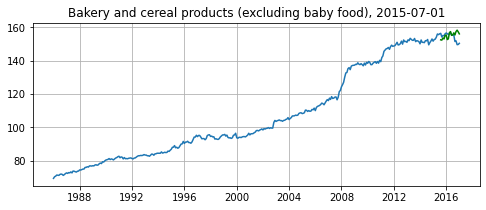

r2_score    -1.51
mae          2.87
mape         0.02
mse         14.52
rmse         3.81
dtype: float64


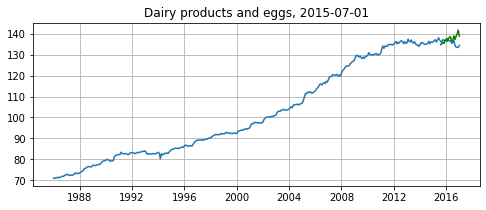

r2_score    -5.12
mae          2.38
mape         0.02
mse         10.30
rmse         3.21
dtype: float64


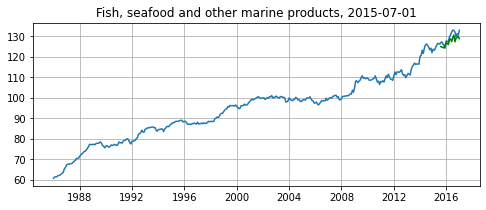

r2_score    0.15
mae         2.10
mape        0.02
mse         6.12
rmse        2.47
dtype: float64


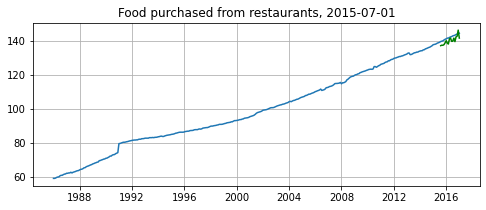

r2_score   -1.53
mae         2.23
mape        0.02
mse         5.75
rmse        2.40
dtype: float64


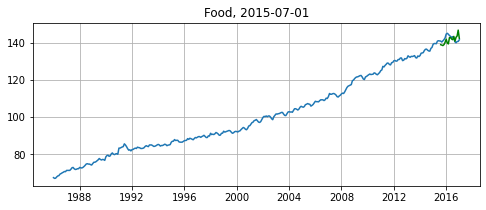

r2_score   -2.27
mae         2.38
mape        0.02
mse         8.31
rmse        2.88
dtype: float64


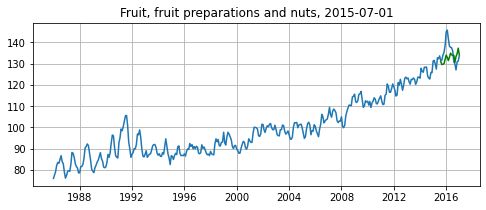

r2_score    -0.38
mae          4.81
mape         0.03
mse         35.18
rmse         5.93
dtype: float64


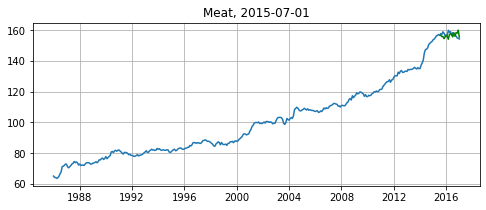

r2_score   -1.85
mae         1.98
mape        0.01
mse         6.47
rmse        2.54
dtype: float64


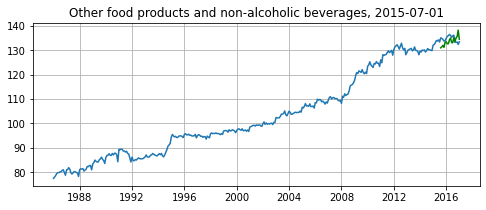

r2_score   -3.90
mae         2.28
mape        0.02
mse         7.02
rmse        2.65
dtype: float64


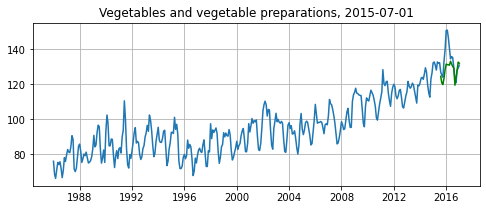

r2_score    -0.02
mae          6.58
mape         0.05
mse         79.97
rmse         8.94
dtype: float64


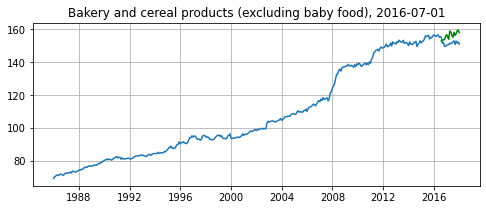

r2_score   -15.58
mae          4.95
mape         0.03
mse         28.21
rmse         5.31
dtype: float64


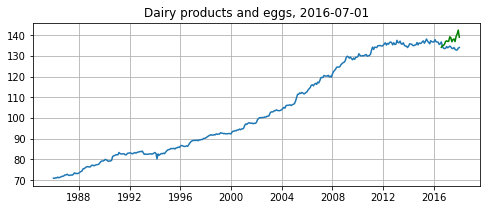

r2_score   -25.84
mae          3.93
mape         0.03
mse         19.66
rmse         4.43
dtype: float64


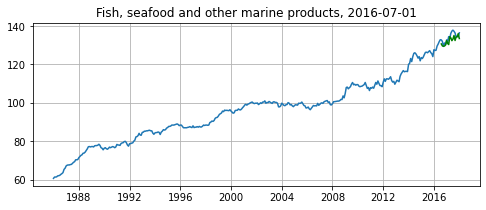

r2_score   -0.06
mae         2.00
mape        0.01
mse         6.43
rmse        2.54
dtype: float64


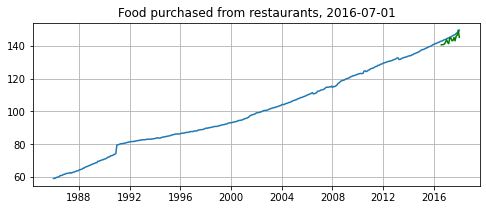

r2_score   -0.68
mae         2.16
mape        0.01
mse         5.89
rmse        2.43
dtype: float64


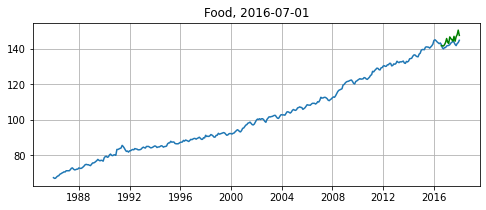

r2_score    -4.95
mae          2.69
mape         0.02
mse         10.36
rmse         3.22
dtype: float64


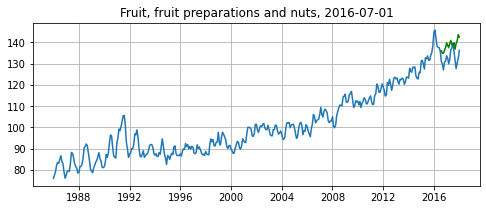

r2_score    -3.31
mae          6.25
mape         0.05
mse         47.26
rmse         6.87
dtype: float64


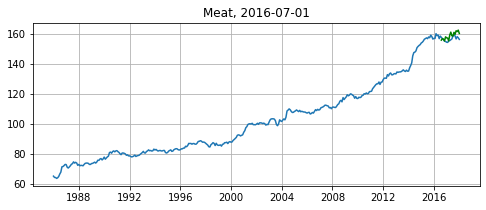

r2_score   -3.21
mae         2.35
mape        0.02
mse         8.88
rmse        2.98
dtype: float64


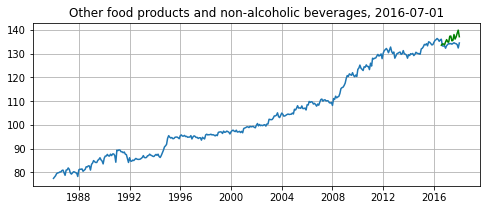

r2_score   -11.32
mae          2.43
mape         0.02
mse          8.73
rmse         2.95
dtype: float64


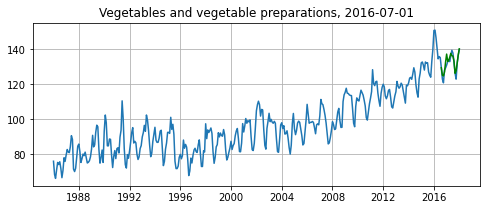

r2_score    0.78
mae         1.79
mape        0.01
mse         6.53
rmse        2.56
dtype: float64


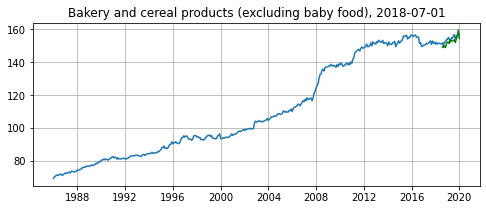

r2_score   -0.29
mae         2.10
mape        0.01
mse         5.14
rmse        2.27
dtype: float64


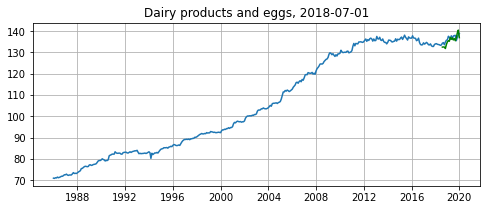

r2_score   -0.51
mae         1.73
mape        0.01
mse         3.34
rmse        1.83
dtype: float64


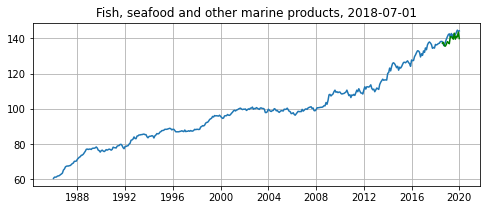

r2_score   -0.13
mae         2.21
mape        0.02
mse         7.44
rmse        2.73
dtype: float64


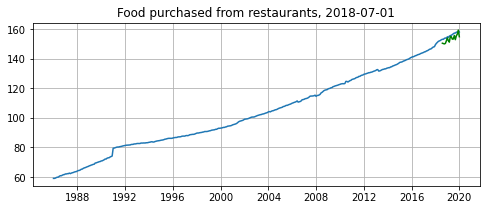

r2_score   -1.52
mae         2.50
mape        0.02
mse         7.54
rmse        2.75
dtype: float64


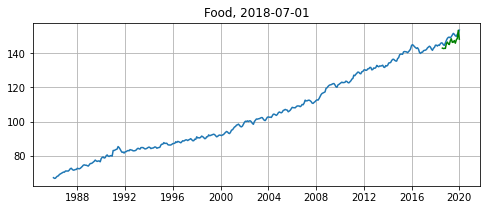

r2_score    -0.80
mae          3.00
mape         0.02
mse         10.60
rmse         3.26
dtype: float64


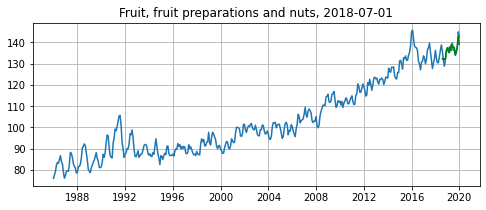

r2_score    0.71
mae         1.57
mape        0.01
mse         3.82
rmse        1.95
dtype: float64


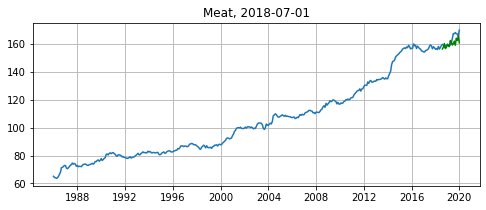

r2_score    -0.11
mae          3.31
mape         0.02
mse         18.85
rmse         4.34
dtype: float64


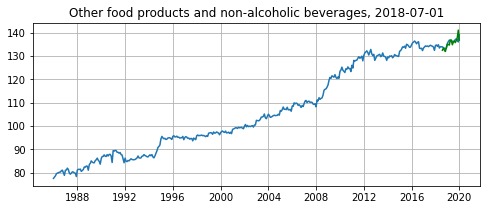

r2_score    4.79e-03
mae         1.15e+00
mape        8.45e-03
mse         2.62e+00
rmse        1.62e+00
dtype: float64


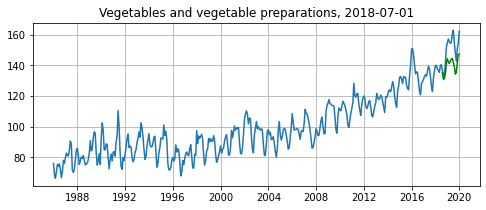

r2_score     -0.70
mae          10.62
mape          0.07
mse         139.77
rmse         11.82
dtype: float64


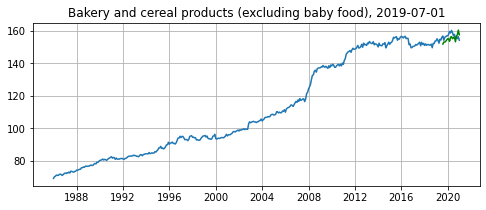

r2_score   -2.51
mae         2.77
mape        0.02
mse         9.63
rmse        3.10
dtype: float64


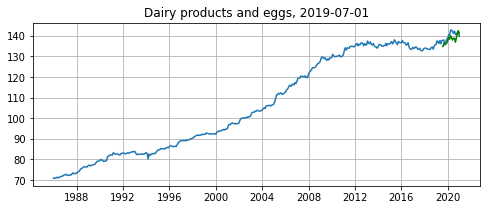

r2_score   -0.35
mae         2.11
mape        0.01
mse         5.70
rmse        2.39
dtype: float64


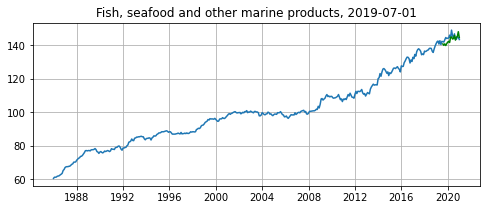

r2_score   -1.32
mae         2.04
mape        0.01
mse         6.04
rmse        2.46
dtype: float64


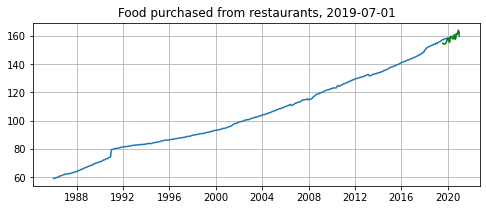

r2_score   -0.89
mae         1.85
mape        0.01
mse         4.96
rmse        2.23
dtype: float64


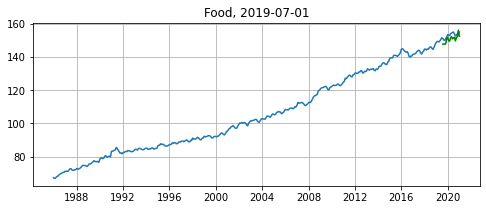

r2_score   -1.98
mae         2.53
mape        0.02
mse         6.97
rmse        2.64
dtype: float64


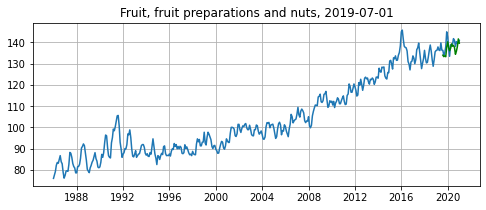

r2_score   -0.05
mae         2.45
mape        0.02
mse         8.91
rmse        2.98
dtype: float64


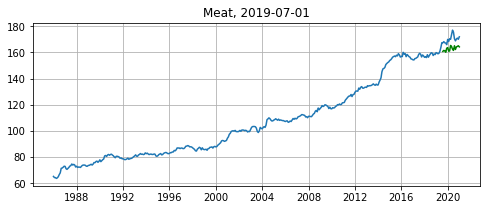

r2_score    -6.74
mae          7.31
mape         0.04
mse         61.62
rmse         7.85
dtype: float64


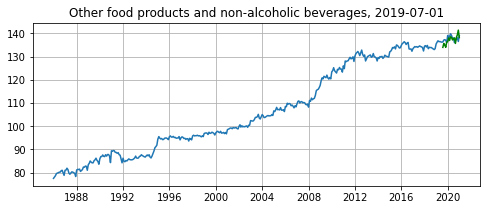

r2_score   -2.07
mae         1.56
mape        0.01
mse         3.78
rmse        1.94
dtype: float64


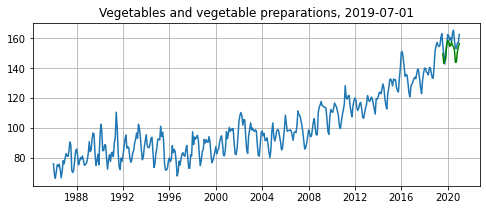

r2_score    -0.11
mae          5.25
mape         0.03
mse         34.91
rmse         5.91
dtype: float64


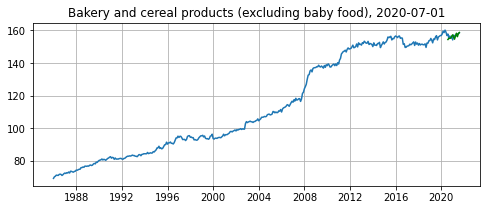

r2_score   -6.13e-01
mae         1.11e+00
mape        7.10e-03
mse         2.44e+00
rmse        1.56e+00
dtype: float64


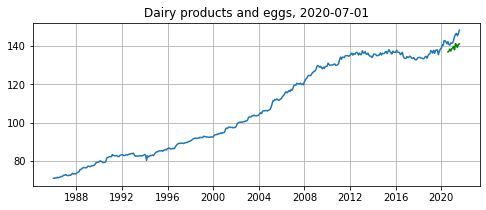

r2_score    -2.92
mae          4.68
mape         0.03
mse         24.48
rmse         4.95
dtype: float64


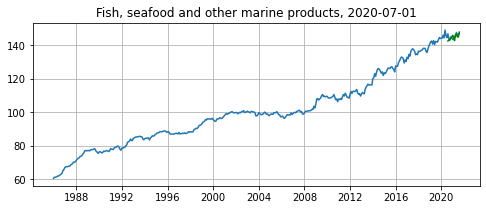

r2_score   -0.68
mae         1.46
mape        0.01
mse         3.18
rmse        1.78
dtype: float64


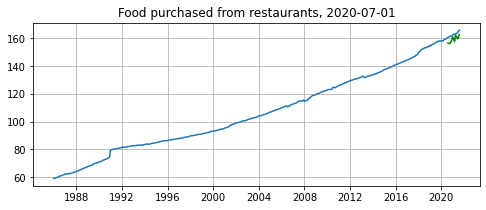

r2_score    -5.41
mae          3.61
mape         0.02
mse         14.76
rmse         3.84
dtype: float64


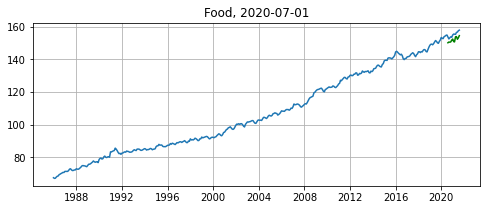

r2_score    -3.16
mae          3.17
mape         0.02
mse         11.20
rmse         3.35
dtype: float64


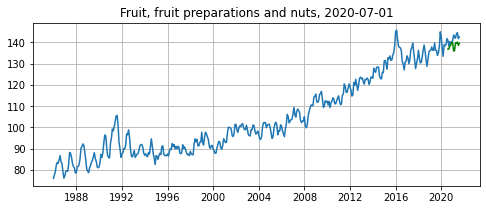

r2_score    -3.61
mae          3.12
mape         0.02
mse         14.15
rmse         3.76
dtype: float64


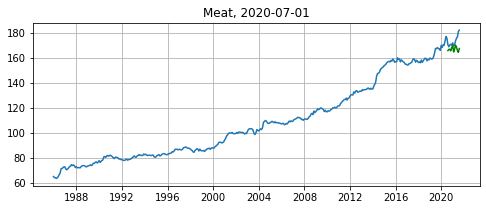

r2_score    -2.36
mae          6.19
mape         0.04
mse         59.86
rmse         7.74
dtype: float64


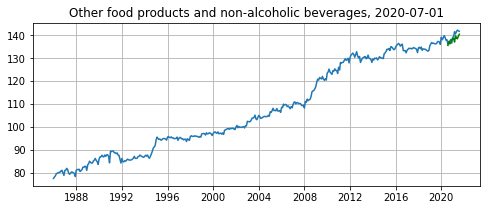

r2_score    0.05
mae         1.69
mape        0.01
mse         4.46
rmse        2.11
dtype: float64


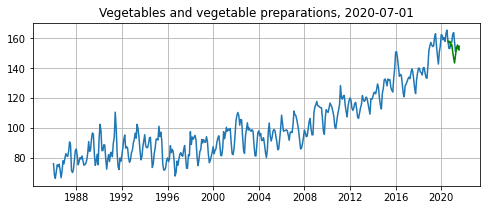

r2_score    -2.81
mae          4.99
mape         0.03
mse         52.71
rmse         7.26
dtype: float64


In [74]:
from gluonts.evaluation import make_evaluation_predictions

report_sim_date = "2016-07-01"

all_valid_metrics = {}

for report_sim_date in report_sim_dates:

    report_train_dates = sim_train_dates[report_sim_date]
    report_valid_dates = sim_valid_dates[report_sim_date]

    valid_ds_report = ListDataset(
        [{'target': x, 'start': start} for x in dataset_df[list(report_train_dates) + list(report_valid_dates)].values],
        freq='MS'
    )

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=valid_ds_report,  # test dataset
        predictor=predictor,  # predictor
    )

    forecasts = list(forecast_it)
    tss = list(ts_it)
    all_fc_dates = list(report_train_dates) + list(report_valid_dates)

    all_food_metrics = {}

    for target_index in range(len(forecasts)):

        # Get food price category
        foodprice_category = foodprice_df.columns[target_index]

        # plot actual
        fig, ax = plt.subplots(figsize=(8,3))
        ax.plot(all_fc_dates, foodprice_df[foodprice_category][all_fc_dates])

        # plot forecast
        forecast_entry = forecasts[target_index]
        ax.plot(report_valid_dates, forecast_entry.mean[:len(report_valid_dates)], color='green')

        plt.title(f"{foodprice_category}, {report_sim_date}")
        plt.grid()
        plt.show()

        fc_metrics = pd.Series({metric_name: metric_fn(y_true=foodprice_df[foodprice_category][report_valid_dates], y_pred=forecast_entry.mean[:len(report_valid_dates)]) for metric_name, metric_fn in metrics.items()})
        print(fc_metrics)

        all_food_metrics[foodprice_category] = fc_metrics

        # print(valid_df)
        # print(valid_forecast)

    all_valid_metrics[report_sim_date] = all_food_metrics

In [111]:
valid_metrics_concat = {}

all_valid_metrics.keys()

for report_date, valid_scores in all_valid_metrics.items():
    valid_metrics_concat[report_date] = pd.DataFrame(valid_scores).T
index = valid_metrics_concat[report_date].index
columns = valid_metrics_concat[report_date].columns
scores = [df.values for date, df in valid_metrics_concat.items()]
mean_scores = pd.DataFrame(np.array(scores).mean(axis=0), index=index, columns=columns)
mean_scores

,r2_score,mae,mape,mse,rmse
Bakery and cereal products (excluding baby food),-4.102,2.761,0.018,11.989,3.211
Dairy products and eggs,-6.949,2.964,0.021,12.693,3.361
"Fish, seafood and other marine products",-0.408,1.959,0.014,5.842,2.396
Food purchased from restaurants,-2.009,2.470,0.016,7.777,2.727
Food,-2.630,2.753,0.019,9.488,3.069
"Fruit, fruit preparations and nuts",-1.328,3.641,0.027,21.864,4.301
Meat,-2.853,4.228,0.025,31.135,5.090
Other food products and non-alcoholic beverages,-3.447,1.822,0.013,5.323,2.256
Vegetables and vegetable preparations,-0.569,5.846,0.039,62.779,7.298


## Fit Models Using All Data To Produce Final Forecast

## Predicted Change in CPI By Category

For the report, we usually express forecasts as the predicted percentage change, overall for the next year. We can do this by comparing the mean forecasted CPI for 2022 to the mean (known and predicted) values for 2021.